In [1]:
!git clone https://github.com/itisdb/Capstone.git

Cloning into 'Capstone'...
remote: Enumerating objects: 2988, done.
remote: Counting objects: 100% (77/77), done.
remote: Compressing objects: 100% (51/51), done.
remote: Total 2988 (delta 22), reused 65 (delta 18), pack-reused 2911
Receiving objects: 100% (2988/2988), 195.93 MiB | 14.19 MiB/s, done.
Resolving deltas: 100% (66/66), done.
Checking out files: 100% (2905/2905), done.


In [2]:
!nvidia-smi

Thu Dec  9 10:42:16 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
# Installing the Keras Dependency
!sudo pip install np_utils

     |████████████████████████████████| 61 kB 2.5 MB/s 
  Created wheel for np-utils: filename=np_utils-0.5.12.1-py3-none-any.whl size=57131 sha256=89de1c8737a17cc1dc6f67894f1f6243b0af0c2ea3f8b873ee242a9764df6381
  Stored in directory: /root/.cache/pip/wheels/8c/4e/ef/095c24693723c329f4cdc1079861cdbb2487d4b41b2496a4e7
Successfully built np-utils


In [4]:
# Import Data
import pandas as pd
import numpy as np

# text preprocessing
from nltk.tokenize import word_tokenize
import re

# plots and metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# preparing input to our model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical

# keras layers
from keras.models import Sequential
from keras.layers import Embedding, Bidirectional, LSTM, GRU, Dense

In [5]:
#Defining vector space dimension and fixed input size

# Number of labels: joy, anger, fear, sadness, neutral
num_classes = 5

# Number of dimensions for word embedding
embed_num_dims = 300

# Max input length (max number of words) 
max_seq_len = 500

class_names = ['joy', 'fear', 'anger', 'sadness', 'neutral']

In [6]:
data_train = pd.read_csv('/content/Capstone/data/data_train.csv', encoding='utf-8')
data_test = pd.read_csv('/content/Capstone/data/data_test.csv', encoding='utf-8')

X_train = data_train.Text
X_test = data_test.Text

y_train = data_train.Emotion
y_test = data_test.Emotion

data = data_train.append(data_test, ignore_index=True)

In [7]:
print(data.Emotion.value_counts())
data.head(6)

joy        2326
sadness    2317
anger      2259
neutral    2254
fear       2171
Name: Emotion, dtype: int64


,Emotion,Text
0,neutral,There are tons of other paintings that I thin...
1,sadness,"Yet the dog had grown old and less capable , a..."
2,fear,When I get into the tube or the train without ...
3,fear,This last may be a source of considerable disq...
4,anger,She disliked the intimacy he showed towards so...
5,sadness,When my family heard that my Mother's cousin w...


In [8]:
#To input the data to our NN Model we'll need some preprocessing:

#Tokenize our texts and count unique tokens
#Padding: each input (sentence or text) has to be of the same lenght
#Labels have to be converted to integeres and categorized

def clean_text(data):
    
    # remove hashtags and @usernames
    data = re.sub(r"(#[\d\w\.]+)", '', data)
    data = re.sub(r"(@[\d\w\.]+)", '', data)
    
    # tekenization using nltk
    data = word_tokenize(data)
    
    return data

In [9]:
#using the NLTK Downloader to obtain the resource
import nltk
nltk.download('punkt')

texts = [' '.join(clean_text(text)) for text in data.Text]

texts_train = [' '.join(clean_text(text)) for text in X_train]
texts_test = [' '.join(clean_text(text)) for text in X_test]

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [10]:
print(texts_train[93])

Fantastic ! I did n't want to come back .


In [11]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)

sequence_train = tokenizer.texts_to_sequences(texts_train)
sequence_test = tokenizer.texts_to_sequences(texts_test)

index_of_words = tokenizer.word_index

# vacab size is number of unique words + reserved 0 index for padding
vocab_size = len(index_of_words) + 1

print('Number of unique words: {}'.format(len(index_of_words)))

Number of unique words: 12088


In [12]:
X_train_pad = pad_sequences(sequence_train, maxlen = max_seq_len )
X_test_pad = pad_sequences(sequence_test, maxlen = max_seq_len )

X_train_pad

array([[    0,     0,     0, ...,   119,    51,   345],
       [    0,     0,     0, ...,    37,   277,   154],
       [    0,     0,     0, ...,    16,     2,  1210],
       ...,
       [    0,     0,     0, ...,   876,     4,   909],
       [    0,     0,     0, ...,     1,     6,   117],
       [    0,     0,     0, ..., 10259,   173,    13]], dtype=int32)

In [13]:
#Categorizing the labels

encoding = {
    'joy': 0,
    'fear': 1,
    'anger': 2,
    'sadness': 3,
    'neutral': 4
}

# Integer labels
y_train = [encoding[x] for x in data_train.Emotion]
y_test = [encoding[x] for x in data_test.Emotion]

In [14]:
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

y_train

array([[0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.]], dtype=float32)

In [15]:
#Importing the pretrained words

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    with open(filepath) as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]
    return embedding_matrix

In [16]:
#We can download and import any pre-trained word embeddings.
#We will use 300 dimentional w2v pre-trained on wikipedia articles.
#Free Resource : https://fasttext.cc/docs/en/english-vectors.html

import urllib.request
import zipfile
import os

fname = 'embeddings/wiki-news-300d-1M.vec'

if not os.path.isfile(fname):
    print('Downloading word vectors...')
    urllib.request.urlretrieve('https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M.vec.zip',
                              'wiki-news-300d-1M.vec.zip')
    print('Unzipping...')
    with zipfile.ZipFile('wiki-news-300d-1M.vec.zip', 'r') as zip_ref:
        zip_ref.extractall('embeddings')
    print('done.')
    
    os.remove('wiki-news-300d-1M.vec.zip')

Unzipping...
done.


In [17]:
embedd_matrix = create_embedding_matrix(fname, index_of_words, embed_num_dims)
embedd_matrix.shape

(12089, 300)

In [18]:
# Inspect unseen words
new_words = 0

for word in index_of_words:
    entry = embedd_matrix[index_of_words[word]]
    if all(v == 0 for v in entry):
        new_words = new_words + 1

print('Words found in wiki vocab: ' + str(len(index_of_words) - new_words))
print('New words found: ' + str(new_words))

Words found in wiki vocab: 11442
New words found: 646


## 3. Create LSTM Pipeline


In [19]:
# Embedding layer before the actaul BLSTM 
embedd_layer = Embedding(vocab_size,
                         embed_num_dims,
                         input_length = max_seq_len,
                         weights = [embedd_matrix],
                         trainable=False)

### Model Pipeline


In [20]:
# Parameters
gru_output_size = 128
bidirectional = True

# Embedding Layer, LSTM or biLSTM, Dense, softmax
model = Sequential()
model.add(embedd_layer)

if bidirectional:
    model.add(Bidirectional(GRU(units=gru_output_size,
                              dropout=0.2,
                              recurrent_dropout=0.2)))
else:
     model.add(GRU(units=gru_output_size,
                dropout=0.2, 
                recurrent_dropout=0.2))

model.add(Dense(num_classes, activation='softmax'))

In [21]:
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          3626700   
                                                                 
 bidirectional (Bidirectiona  (None, 256)              330240    
 l)                                                              
                                                                 
 dense (Dense)               (None, 5)                 1285      
                                                                 
Total params: 3,958,225
Trainable params: 331,525
Non-trainable params: 3,626,700
_________________________________________________________________


## 3. Train the Model


In [22]:
batch_size = 128
epochs = 30

hist = model.fit(X_train_pad, y_train, 
                 batch_size=batch_size,
                 epochs=epochs,
                 validation_data=(X_test_pad,y_test))

Epoch 1/30
62/62 [==============================] - 310s 5s/step - loss: 1.4106 - accuracy: 0.3848 - val_loss: 1.2656 - val_accuracy: 0.4798
Epoch 2/30
62/62 [==============================] - 304s 5s/step - loss: 1.0912 - accuracy: 0.5689 - val_loss: 0.9592 - val_accuracy: 0.6393
Epoch 3/30
62/62 [==============================] - 301s 5s/step - loss: 0.8861 - accuracy: 0.6725 - val_loss: 0.8353 - val_accuracy: 0.7011
Epoch 4/30
62/62 [==============================] - 301s 5s/step - loss: 0.7805 - accuracy: 0.7163 - val_loss: 0.8096 - val_accuracy: 0.7050
Epoch 5/30
62/62 [==============================] - 302s 5s/step - loss: 0.7438 - accuracy: 0.7265 - val_loss: 0.7774 - val_accuracy: 0.7235
Epoch 6/30
62/62 [==============================] - 301s 5s/step - loss: 0.7241 - accuracy: 0.7388 - val_loss: 0.7716 - val_accuracy: 0.7165
Epoch 7/30
62/62 [==============================] - 301s 5s/step - loss: 0.6934 - accuracy: 0.7492 - val_loss: 0.7516 - val_accuracy: 0.7289
Epoch 8/30
62

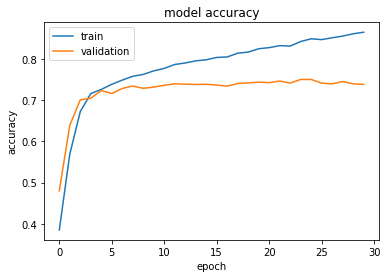

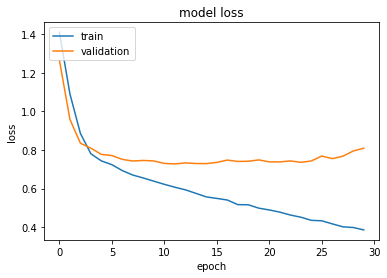

In [23]:
#  "Accuracy"
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Evaluation

In [24]:
predictions = model.predict(X_test_pad)
predictions = np.argmax(predictions, axis=1)
predictions = [class_names[pred] for pred in predictions]

In [25]:
print("Accuracy: {:.2f}%".format(accuracy_score(data_test.Emotion, predictions) * 100))
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

Accuracy: 73.86%

F1 Score: 73.86


In [26]:
# creates a HDF5 file 'my_model.h5'
model.save('/content/drive/MyDrive//Capstone/models/biLSTM_w2v.h5')

In [27]:
from keras.models import load_model
predictor = load_model('/content/Capstone/models/biLSTM_w2v.h5')

In [28]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    '''
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    '''
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()
    
    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)
    
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


F1 Score: 73.86


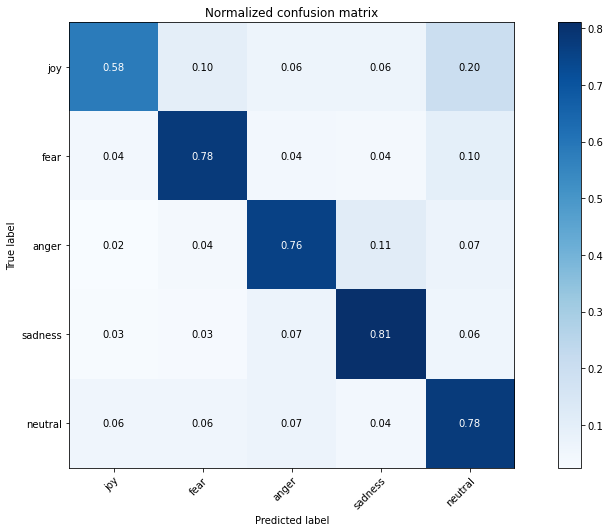

In [29]:
print("\nF1 Score: {:.2f}".format(f1_score(data_test.Emotion, predictions, average='micro') * 100))

# Plot normalized confusion matrix
plot_confusion_matrix(data_test.Emotion, predictions, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

In [30]:
print('Message: {}\nPredicted: {}'.format(X_test[4], predictions[4]))

Message: My boyfriend didn't turn up after promising that he was coming.
Predicted: sadness


In [31]:
import time

message = ['i have been really going through rough days']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['i have been really going through rough days']
predicted: sadness (0.40 seconds)


In [32]:
import time

message = ['This is fine day']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['This is fine day']
predicted: neutral (0.39 seconds)


In [33]:
import time

message = ['that man over there is running fast']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['that man over there is running fast']
predicted: fear (0.40 seconds)


In [34]:
import time

message = ['congratulations thats a big news']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['congratulations thats a big news']
predicted: joy (0.40 seconds)


In [35]:
import time

message = ['i could not have been more merry']

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('Message: ' + str(message))
print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Message: ['i could not have been more merry']
predicted: sadness (0.67 seconds)


# Voice Prediction:

In [36]:
#installing all the packages required for speech input and recognition

!sudo apt-get install portaudio19-dev python-pyaudio
!sudo apt-get install python-gnuradio-audio-portaudio
!pip install PyAudio
!pip install SpeechRecognition
!pip install pyttsx3
!pip install wavio
!pip install pydub

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  libportaudio2 libportaudiocpp0
Suggested packages:
  portaudio19-doc python-pyaudio-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev python-pyaudio
0 upgraded, 4 newly installed, 0 to remove and 37 not upgraded.
Need to get 208 kB of archives.
After this operation, 999 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudio2 amd64 19.6.0-1 [64.6 kB]
Get:2 http://archive.ubuntu.com/ubuntu bionic/universe amd64 libportaudiocpp0 amd64 19.6.0-1 [15.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu bionic/universe amd64 portaudio19-dev amd64 19.6.0-1 [104 kB]
Get:4 http://archive.ubuntu.com/ubuntu bionic/universe amd64 python-pyaudio amd64 0.2.11-1build2 [24.1 kB]
Fetched 208 kB in 2s (130 kB/s)
debconf: unable to initialize frontend: Dial

In [37]:
# all imports
import numpy as np
from IPython.display import Javascript
from google.colab import output
from base64 import b64decode
from pydub import AudioSegment

# js script needed to record input from colab
RECORD = """
const sleep = time => new Promise(resolve => {
setTimeout(resolve, time)
}, )
const b2text = blob => new Promise(resolve => {
const reader = new FileReader()
reader.onloadend = e => resolve(e.srcElement.result)
reader.readAsDataURL(blob)
})
var espacio = document.querySelector("#output-area")
var record = time => new Promise(async resolve => {
stream = await navigator.mediaDevices.getUserMedia({ audio: true })
recorder = new MediaRecorder(stream)
chunks = []
recorder.ondataavailable = e => chunks.push(e.data)
recorder.start()
var numerillo = (time/1000)-1
for (var i = 0; i < numerillo; i++) {
espacio.appendChild(document.createTextNode(numerillo-i))
await sleep(1000)
espacio.removeChild(espacio.lastChild)
}
recorder.onstop = async ()=>{
blob = new Blob(chunks)
text = await b2text(blob)
resolve(text)
}
recorder.stop()
})
"""

#record function that will record the audio for a default of 5 secs
def record(sec=5):
  display(Javascript(RECORD))
  s = output.eval_js('record(%d)' % (sec*1000))
  b = b64decode(s.split(',')[1])
  with open('audio.wav','wb') as f:
    f.write(b)
  return 'audio.wav'  # or webm ?


#conversion of the .wav file into a readable format for speechrecognizer
EXPECTED_SAMPLE_RATE = 16000

def convert_audio_for_model(user_file, output_file='converted_audio_file.wav'):
  audio = AudioSegment.from_file(user_file)
  audio = audio.set_frame_rate(EXPECTED_SAMPLE_RATE).set_channels(1)
  audio.export(output_file, format="wav")
  return output_file

In [39]:
#recognition of speech using SpeeechRecognition Package
import speech_recognition as sr
import time

r = sr.Recognizer()
n=int(input("Enter the number of seconds:"))
print("Speak Anything :")
print("Time Remaining:")
wave=record(n)
converted_audio_file = convert_audio_for_model(wave)

# obtain audio from the microphone
r = sr.Recognizer()
with sr.AudioFile('/content/converted_audio_file.wav') as source:
    audio = r.record(source) #read the wave file from the source

# recognize speech using Google Speech Recognition
try:
    # for testing purposes, we're just using the default API key
    # to use another API key, use `r.recognize_google(audio, key="GOOGLE_SPEECH_RECOGNITION_API_KEY")`
    # instead of `r.recognize_google(audio)`
    text=r.recognize_google(audio)
    print("You said:  " + text)
except sr.UnknownValueError:
    print("AI could not understand audio")
except sr.RequestError as e:
    print("Could not request results from Google Speech Recognition service; {0}".format(e))


# Python code to convert string to list
# We need it as input into the lstm pipeline is done with list and the output from the StT is in String  
def Convert(string):
    li = list(string.split(" "))
    return li

#Message encoding
message = [' '.join(Convert(text))]

seq = tokenizer.texts_to_sequences(message)
padded = pad_sequences(seq, maxlen=max_seq_len)

start_time = time.time()
pred = model.predict(padded)

print('predicted: {} ({:.2f} seconds)'.format(class_names[np.argmax(pred)], (time.time() - start_time)))

Enter the number of seconds:10
Speak Anything :
Time Remaining:


<IPython.core.display.Javascript object>

You said:  that room is creepy
predicted: fear (0.41 seconds)
